In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [98]:
import numpy as np
import json
from equistore import Labels, TensorBlock, TensorMap
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
import matplotlib.pyplot as plt
from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from rascal.representations import SphericalExpansion
import copy
from utils.model_hamiltonian import *
from ase.units import Hartree

## Manipulate Hamiltonian into blocks

In [3]:
frames = ase.io.read("data/hamiltonian/water-hamiltonian/water_coords_1000.xyz",":1000")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [4]:
#jorbs = json.load(open('data/water-hamiltonian/water_orbs.json', "r"))
jorbs = json.loads(json.load(open('data/hamiltonian/water-hamiltonian/water_orbs.json', "r")))
orbs = {}
zdic = {"O" : 8, "H":1}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

In [5]:
hams = np.load("data/hamiltonian/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]
eigvals = np.linalg.eigvalsh(hams)
# NO NEED TO CORRECT L1 ORDER FOR SAPH ORTHOGONALIZED MATRICES...
#for i, f in enumerate(frames):
#    hams[i] = fix_pyscf_l1(hams[i], f, orbs)

blocks = dense_to_blocks(hams, frames, orbs)

In [6]:
cg = ClebschGordanReal(5)

In [7]:
coupled = couple_blocks(blocks, cg)

fock_bc = coupled

## Feature computation

In [8]:
rascal_hypers = {
    "interaction_cutoff": 2.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 4,
    "max_angular": 3,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [9]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [10]:
mc_rho1i = acdc_standardize_keys(rhoi)
mc_rho1i.keys_to_properties(['species_neighbor'])
mc_gij =  acdc_standardize_keys(gij)

In [11]:
?cg_increment

In [12]:
%%time
mc_rho2i = cg_increment(mc_rho1i, mc_rho1i, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 1.34 s, sys: 126 ms, total: 1.47 s
Wall time: 1.48 s


In [ ]:
%%time
mc_rho3i = cg_increment(mc_rho2i, mc_rho1i, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

In [13]:
%%time
mc_rho1ij = cg_increment(mc_rho1i, mc_gij, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 2.38 s, sys: 117 ms, total: 2.5 s
Wall time: 2.5 s


In [ ]:
%%time
mc_rho2ij = cg_increment(mc_rho2i, mc_gij, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

In [ ]:
%lprun -f cg_combine cg_increment(mc_rho2i, mc_gij, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

In [ ]:
np.linalg.norm(mc_rho2i.block(0).values)
# 0.001486930385468841

In [14]:
ham_feats = hamiltonian_features(mc_rho2i, mc_rho1ij)

## Testing model on one structure

In [19]:
mc_rho2ij.block(0).samples.names

('structure', 'center', 'neighbor')

In [20]:
%%time
ts = ham_feats.slice(
                 Labels(names=["structure"], values=np.asarray([1,3,5,7,9], dtype=np.int32).reshape(-1,1)),
                 Labels(names=["species_neighbor_1", "species_neighbor_2"], values=np.asarray([[1,1],[1,8]], dtype=np.int32).reshape(-1,2)),
                )

CPU times: user 685 ms, sys: 175 ms, total: 861 ms
Wall time: 1.61 s


In [21]:
ts.block(0).samples

Labels([(1, 1, 1), (1, 2, 2), (3, 1, 1), (3, 2, 2), (5, 1, 1), (5, 2, 2),
        (7, 1, 1), (7, 2, 2), (9, 1, 1), (9, 2, 2)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('neighbor', '<i4')])

In [22]:
%lprun -f TensorMap.slice ham_feats.slice(Labels(names=["structure"], values=np.asarray([1,3,5,7,9], dtype=np.int32).reshape(-1,1)), Labels(names=["species_neighbor_1", "species_neighbor_2"], values=np.asarray([[1,1],[1,8]], dtype=np.int32).reshape(-1,2)),)

In [102]:
FR = Fock_regression(alpha=1e-8)

In [107]:
aa = FR.fit(ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(80), dtype=np.int32).reshape(-1,1)) ),
       fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(80), dtype=np.int32).reshape(-1,1)) ))

In [108]:
pred_dense, pred_eigvals = FR.predict(ham_feats, frames, orbs)

In [110]:
np.abs(np.mean(hams - pred_dense))*Hartree

0.010936439434580955

In [106]:
eigval_loss = []
for i in range(len(frames)):
    eigval_loss.append(eigvals[i] - pred_eigvals[i])

np.abs(np.mean(eigval_loss))

3.608952066203261e-05

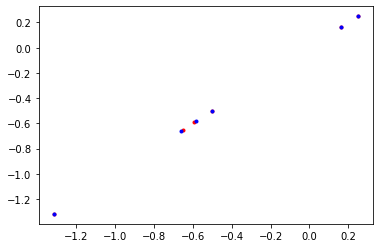

In [20]:
plt.plot(eigvals[8], pred_eigvals[8], 'r.')
plt.plot(eigvals[980], pred_eigvals[980], 'b.')

## Learning curve

In [ ]:
FR = Fock_regression(alpha=1e-8)

In [99]:
tf = [80, 160, 240, 320, 400, 480, 560, 640, 720, 800]
mae_full = []
mae_eva = []
for i in tf:
    aa = FR.fit(ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(i), dtype=np.int32).reshape(-1,1)) ),
       fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(i), dtype=np.int32).reshape(-1,1)) ))
    pred_dense, pred_eigvals = FR.predict(ham_feats, frames, orbs)
    
    mae_full.append(np.abs(np.mean(hams - pred_dense))*Hartree)
    eigval_loss = []
    for a in range(len(frames)):
        eigval_loss.append(eigvals[a] - pred_eigvals[a])

    mae_eva.append(np.abs(np.mean(eigval_loss))*Hartree)

Text(0, 0.5, 'MAE/eV')

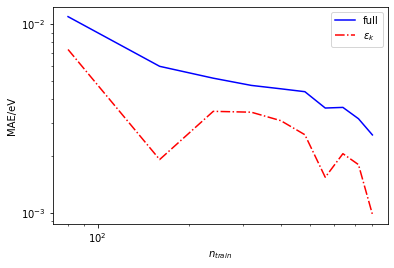

In [100]:
plt.loglog(tf, mae_full, 'b', label='full')
plt.loglog(tf, mae_eva, 'r-.', label='$\epsilon_{k}$')
plt.legend(loc ="upper right");
plt.xlabel('$n_{train}$')
plt.ylabel('MAE/eV')

In [29]:
#for i in range(len(fock_bc.keys)):
#    print(pred.keys[i])
#    print(pred.block(i).values.flatten() - fock_bc.block(i).values.flatten())

## Rotated features for a rotated molecule

In [30]:
rot_frame = frames[0].copy()
rot_frame.positions = 50+(50-frames[0].positions[:,[2,0,1]])
rot_frame.positions[:,]

array([[50.      , 50.      , 50.      ],
       [50.      , 49.165109, 50.      ],
       [50.      , 49.905969, 49.038666]])

In [31]:
rhoi = spex.compute([rot_frame])

In [32]:
gij = pairs.compute([rot_frame])

In [33]:
rot_rho1i = acdc_standardize_keys(rhoi)
rot_rho1i.keys_to_properties(['species_neighbor'])
rot_gij =  acdc_standardize_keys(gij)

In [34]:
rot_rho2i = cg_increment(rot_rho1i, rot_rho1i, lcut=4, other_keys_match=["species_center"])

In [35]:
rot_rho3i = cg_increment(rot_rho2i, rot_rho1i, lcut=4, other_keys_match=["species_center"])

In [36]:
rot_rho1ij = cg_increment(rot_rho1i, rot_gij, lcut=4, other_keys_match=["species_center"])

In [37]:
rot_rho2ij = cg_increment(rot_rho2i, rot_gij, lcut=4, other_keys_match=["species_center"])

In [38]:
rot_feats = hamiltonian_features(rot_rho3i, rot_rho2ij)

In [39]:
rot_dense, rot_eigvals = FR.predict(rot_feats, [rot_frame], orbs)

In [40]:
pred_eigvals[0]

array([-1.37727437, -0.69013755, -0.61864914, -0.50999836,  0.17422147,
        0.26759468])

In [41]:
rot_eigvals[0]

array([-1.37727437, -0.69013755, -0.61864914, -0.50999836,  0.17422147,
        0.26759468])

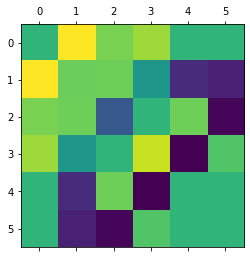

In [42]:
plt.matshow(pred_dense[0]- rot_dense[0])

In [43]:
pred_dense[0]- rot_dense[0]

array([[ 5.55111512e-16,  2.21568619e-01,  9.41577282e-02,
         1.27410891e-01,  1.11022302e-16,  0.00000000e+00],
       [ 2.21568619e-01,  7.45705559e-02,  8.04474875e-02,
        -8.04474875e-02, -3.37191943e-01, -3.58881322e-01],
       [ 9.41577282e-02,  8.04474875e-02, -2.42362213e-01,
         0.00000000e+00,  8.03017999e-02, -4.06791999e-01],
       [ 1.27410891e-01, -8.04474875e-02,  0.00000000e+00,
         1.67791657e-01, -4.17493743e-01,  4.79106778e-02],
       [ 1.11022302e-16, -3.37191943e-01,  8.03017999e-02,
        -4.17493743e-01, -1.11022302e-16,  2.77555756e-17],
       [ 0.00000000e+00, -3.58881322e-01, -4.06791999e-01,
         4.79106778e-02,  2.77555756e-17, -5.55111512e-17]])